##### [sample solution that works]

# This tutorial is will bring you through your first deep reinforcement learning model


* Seaquest game as an example
* Training a simple lasagne neural network for Q_learning objective


## About OpenAI Gym

* Its a recently published platform that basicly allows you to train agents in a wide variety of environments with near-identical interface.
* This is twice as awesome since now we don't need to write a new wrapper for every game
* Go check it out!
  * Blog post - https://openai.com/blog/openai-gym-beta/
  * Github - https://github.com/openai/gym


## New to Lasagne and AgentNet?
* We only require surface level knowledge of theano and lasagne, so you can just learn them as you go.
* Alternatively, you can find Lasagne tutorials here:
 * Official mnist example: http://lasagne.readthedocs.io/en/latest/user/tutorial.html
 * From scratch: https://github.com/ddtm/dl-course/tree/master/Seminar4
 * From theano: https://github.com/craffel/Lasagne-tutorial/blob/master/examples/tutorial.ipynb
* This is pretty much the basic tutorial for AgentNet, so it's okay not to know it.


# Experiment setup
* Here we basically just load the game and check that it works

In [1]:
%env THEANO_FLAGS="device=gpu0"
import theano
theano.config.floatX = 'float32'

env: THEANO_FLAGS="device=gpu0"


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


In [2]:
#global params.

#game title. full list of games = http://yavar.naddaf.name/ale/list_of_current_games.html
GAME="GopherDeterministic-v0"

#number of parallel agents and batch sequence length (frames)
N_AGENTS = 50
SEQ_LENGTH = 10

In [3]:

#game image will be resized from (210,160) to your image_size. 
#You may want a bigger image for your homework assignment IF you want a larger NN
IMAGE_W,IMAGE_H = IMAGE_SIZE =(105,80)
from scipy.misc import imresize
def preprocess(obs):
    obs= imresize(obs,IMAGE_SIZE)
    return obs.mean(-1)/255.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

[2016-12-07 21:05:20,127] Making new env: GopherDeterministic-v0


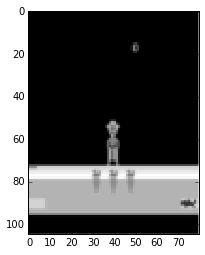

In [5]:
import gym

#creating a game
atari = gym.make(GAME)

action_names = np.array(atari.get_action_meanings())

obs = atari.step(0)[0]

plt.imshow(preprocess(obs),interpolation='none',cmap='gray')

# Basic agent setup
Here we define a simple agent that maps game images into Qvalues using simple convolutional neural network.

![scheme](https://s18.postimg.org/gbmsq6gmx/dqn_scheme.png)

In [6]:
import lasagne

In [7]:
from lasagne.layers import *
#image observation at current tick goes here, shape = (sample_i,x,y)
observation_layer = InputLayer((None,IMAGE_W,IMAGE_H))

In [8]:
from agentnet.memory import WindowAugmentation,LSTMCell,RNNCell

#store 4-tick window in order to perceive motion of objects

prev_window = InputLayer((None,4,IMAGE_W,IMAGE_H))

current_window = WindowAugmentation(observation_layer,prev_window)

In [9]:
from lasagne.layers import Conv2DLayer,Pool2DLayer,DenseLayer,batch_norm,dropout

#main neural network body
conv0 = Conv2DLayer(current_window,16,filter_size=(8,8),stride=(4,4),name='conv0')

conv1 = Conv2DLayer(conv0,32,filter_size=(4,4),stride=(2,2),name='conv1')

dense0 = DenseLayer(conv1,256,name='dense',nonlinearity = lasagne.nonlinearities.tanh)

#please set this to your last layer for convenience
last_layer = dense0

In [10]:
#a layer that predicts Qvalues
qvalues_layer = DenseLayer(last_layer,
                   num_units = atari.action_space.n,
                   nonlinearity=lasagne.nonlinearities.linear,
                   name="q-evaluator layer")

#To pick actions, we use an epsilon-greedy resolver (epsilon is a property)
from agentnet.resolver import EpsilonGreedyResolver
action_layer = EpsilonGreedyResolver(qvalues_layer,name="e-greedy action picker")

action_layer.epsilon.set_value(np.float32(0.1))


In [11]:
from agentnet.target_network import TargetNetwork
targetnet = TargetNetwork(qvalues_layer,dense0)


In [12]:
qvalues_old = targetnet.output_layers

##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [13]:
from agentnet.agent import Agent
#all together
agent = Agent(observation_layers=observation_layer,
              policy_estimators=(qvalues_layer,qvalues_old),
              agent_states={current_window:prev_window},
              action_layers=action_layer)


In [14]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(action_layer,trainable=True)
weights

[conv0.W,
 conv0.b,
 conv1.W,
 conv1.b,
 dense.W,
 dense.b,
 q-evaluator layer.W,
 q-evaluator layer.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [15]:
from agentnet.experiments.openai_gym.pool import EnvPool

pool = EnvPool(agent,GAME, N_AGENTS,max_size=1000,preprocess_observation=preprocess) #may need to adjust for speed


[2016-12-07 21:06:14,035] Making new env: GopherDeterministic-v0
[2016-12-07 21:06:14,080] Making new env: GopherDeterministic-v0
[2016-12-07 21:06:14,114] Making new env: GopherDeterministic-v0
[2016-12-07 21:06:14,146] Making new env: GopherDeterministic-v0
[2016-12-07 21:06:14,179] Making new env: GopherDeterministic-v0
[2016-12-07 21:06:14,212] Making new env: GopherDeterministic-v0
[2016-12-07 21:06:14,244] Making new env: GopherDeterministic-v0
[2016-12-07 21:06:14,279] Making new env: GopherDeterministic-v0
[2016-12-07 21:06:14,312] Making new env: GopherDeterministic-v0
[2016-12-07 21:06:14,345] Making new env: GopherDeterministic-v0
[2016-12-07 21:06:14,378] Making new env: GopherDeterministic-v0
[2016-12-07 21:06:14,410] Making new env: GopherDeterministic-v0
[2016-12-07 21:06:14,442] Making new env: GopherDeterministic-v0
[2016-12-07 21:06:14,475] Making new env: GopherDeterministic-v0
[2016-12-07 21:06:14,507] Making new env: GopherDeterministic-v0
[2016-12-07 21:06:14,539]

In [16]:
%%time
#interact for 7 ticks
_,action_log,reward_log,_,_,_  = pool.interact(7)


print(action_names[action_log][:2])
print(reward_log[:2])

[['NOOP' 'NOOP' 'UP' 'UP' 'FIRE' 'UP' 'LEFT']
 ['NOOP' 'NOOP' 'UP' 'LEFTFIRE' 'UP' 'UP' 'LEFTFIRE']]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]]
CPU times: user 1.29 s, sys: 47 ms, total: 1.33 s
Wall time: 1.33 s


In [17]:
#load first sessions (this function calls interact and remembers sessions)
pool.update(SEQ_LENGTH)

# Q-learning
* An agent has a method that produces symbolic environment interaction sessions
* Such sessions are in sequences of observations, agent memory, actions, q-values,etc
  * one has to pre-define maximum session length.

* SessionPool also stores rewards (Q-learning objective)

In [18]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100,replace=True)

_,_,_,_,(qvalues_seq,old_qvalues_seq) = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    optimize_experience_replay=True,
)



In [19]:
#get reference Qvalues according to Qlearning algorithm
from agentnet.learning import qlearning

#crop rewards to [-1,+1] to avoid explosion.
import theano.tensor as T
rewards = T.maximum(-1,T.minimum(replay.rewards,1))

#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2

elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      replay.actions[0],
                                                      rewards,
                                                      replay.is_alive,
                                                      Qvalues_target=old_qvalues_seq,
                                                      gamma_or_gammas=0.99,)

#compute mean over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [20]:
# Compute weight updates
updates = lasagne.updates.adadelta(loss,weights)

In [21]:
#compile train function
import theano
train_step = theano.function([],loss,updates=updates)

# Demo run

In [22]:
action_layer.epsilon.set_value(0)

In [23]:
untrained_reward = pool.evaluate(save_path="./records",record_video=False)

[2016-12-07 21:06:55,004] Making new env: GopherDeterministic-v0
[2016-12-07 21:06:55,052] Clearing 2 monitor files from previous run (because force=True was provided)
[2016-12-07 21:07:59,659] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/apanin/jheuristic/drqn/records')


Episode finished after 10001 timesteps with reward=0.0


In [24]:
from IPython.display import HTML

video_path="records/openaigym.video.32.9829.video000000.mp4"

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_path))


# Training loop

In [ ]:
#starting epoch
epoch_counter = 1

#full game rewards
rewards = {epoch_counter:untrained_reward}

In [ ]:

#the loop may take eons to finish.
#consider interrupting early.
for i in xrange(10**7):    
    
    
    #train
    pool.update(SEQ_LENGTH,append=True)
    
    for i in range(5): #you may want to increase the number of training iterations per one update
        loss = train_step()
        
    targetnet.load_weights(0.01)
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    current_epsilon = 0.05 + 0.95*np.exp(-epoch_counter/5000.)
    action_layer.epsilon.set_value(np.float32(current_epsilon))
    
    if epoch_counter%10==0:
        #average reward per game tick in current experience replay pool
        pool_mean_reward = pool.experience_replay.rewards.get_value().mean()
        print("iter=%i\tepsilon=%.3f\treward/step=%.5f"%(epoch_counter,
                                                         current_epsilon,
                                                         pool_mean_reward))
        
    ##record current learning progress and show learning curves
    if epoch_counter%100 ==0:
        action_layer.epsilon.set_value(0)
        rewards[epoch_counter] = pool.evaluate(record_video=False)
        action_layer.epsilon.set_value(np.float32(current_epsilon))
#         plt.title("random frames")
#         for i in range(min((len(pool.games),6))):
#             plt.subplot(2,3,i+1)
#             plt.imshow(pool.games[i].get_observation())
#         plt.show()

    
    epoch_counter  +=1

    
# Time to drink some coffee!

iter=30570	epsilon=0.052	reward/step=0.61800
iter=30580	epsilon=0.052	reward/step=0.66400
iter=30590	epsilon=0.052	reward/step=0.58800


[2016-12-09 05:26:12,554] Making new env: GopherDeterministic-v0
[2016-12-09 05:26:12,614] Clearing 2 monitor files from previous run (because force=True was provided)


iter=30600	epsilon=0.052	reward/step=0.55600


[2016-12-09 05:26:28,778] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/apanin/jheuristic/drqn/records')


Episode finished after 1938 timesteps with reward=1820.0
iter=30610	epsilon=0.052	reward/step=0.64200
iter=30620	epsilon=0.052	reward/step=0.64000
iter=30630	epsilon=0.052	reward/step=0.57800
iter=30640	epsilon=0.052	reward/step=0.68200
iter=30650	epsilon=0.052	reward/step=0.79400
iter=30660	epsilon=0.052	reward/step=0.71000
iter=30670	epsilon=0.052	reward/step=0.59800
iter=30680	epsilon=0.052	reward/step=0.62400
iter=30690	epsilon=0.052	reward/step=0.67000


[2016-12-09 05:32:38,198] Making new env: GopherDeterministic-v0
[2016-12-09 05:32:38,254] Clearing 2 monitor files from previous run (because force=True was provided)


iter=30700	epsilon=0.052	reward/step=0.62000


[2016-12-09 05:32:44,270] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/apanin/jheuristic/drqn/records')


Episode finished after 647 timesteps with reward=120.0
iter=30710	epsilon=0.052	reward/step=0.61400
iter=30720	epsilon=0.052	reward/step=0.63600
iter=30730	epsilon=0.052	reward/step=0.78400
iter=30740	epsilon=0.052	reward/step=0.78800
iter=30750	epsilon=0.052	reward/step=0.70400
iter=30760	epsilon=0.052	reward/step=0.79800
iter=30770	epsilon=0.052	reward/step=0.82800
iter=30780	epsilon=0.052	reward/step=0.75200
iter=30790	epsilon=0.052	reward/step=0.63200


[2016-12-09 05:38:47,367] Making new env: GopherDeterministic-v0
[2016-12-09 05:38:47,423] Clearing 2 monitor files from previous run (because force=True was provided)


iter=30800	epsilon=0.052	reward/step=0.66000


[2016-12-09 05:38:57,816] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/apanin/jheuristic/drqn/records')


Episode finished after 1112 timesteps with reward=1020.0
iter=30810	epsilon=0.052	reward/step=0.61800
iter=30820	epsilon=0.052	reward/step=0.51200
iter=30830	epsilon=0.052	reward/step=0.59600
iter=30840	epsilon=0.052	reward/step=0.68200
iter=30850	epsilon=0.052	reward/step=0.69000
iter=30860	epsilon=0.052	reward/step=0.66600
iter=30870	epsilon=0.052	reward/step=0.70800
iter=30880	epsilon=0.052	reward/step=0.71200
iter=30890	epsilon=0.052	reward/step=0.74000


[2016-12-09 05:45:03,201] Making new env: GopherDeterministic-v0
[2016-12-09 05:45:03,253] Clearing 2 monitor files from previous run (because force=True was provided)


iter=30900	epsilon=0.052	reward/step=0.70800


[2016-12-09 05:45:15,301] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/apanin/jheuristic/drqn/records')


Episode finished after 1306 timesteps with reward=960.0
iter=30910	epsilon=0.052	reward/step=0.65600
iter=30920	epsilon=0.052	reward/step=0.74600
iter=30930	epsilon=0.052	reward/step=0.76400
iter=30940	epsilon=0.052	reward/step=0.78000
iter=30950	epsilon=0.052	reward/step=0.75000


# Evaluating results
 * Here we plot learning curves and sample testimonials

/home/apanin/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)
/home/apanin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  app.launch_new_instance()


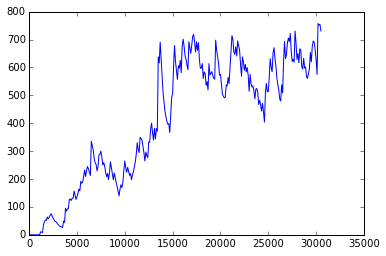

In [27]:
import pandas as pd
t,r = zip(*sorted(rewards.items(),key=lambda k:k[0]))
plt.plot(t,pd.ewma(np.concatenate(r),alpha=0.1))

In [30]:
from agentnet.utils.persistence import save
save(action_layer,"gopher.pcl")

In [ ]:
###LOAD FROM HERE
from agentnet.utils.persistence import load
load(action_layer,"gopher.pcl")

In [29]:
action_layer.epsilon.set_value(0.05)
rw = pool.evaluate(n_games=20,save_path="./records",record_video=False)
print("mean session score=%f.5"%np.mean(rw))

[2016-12-09 05:10:23,215] Making new env: GopherDeterministic-v0
[2016-12-09 05:10:23,282] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 741 timesteps with reward=200.0
Episode finished after 796 timesteps with reward=480.0
Episode finished after 1956 timesteps with reward=1540.0
Episode finished after 1094 timesteps with reward=360.0
Episode finished after 1052 timesteps with reward=600.0
Episode finished after 756 timesteps with reward=320.0
Episode finished after 1456 timesteps with reward=800.0
Episode finished after 1021 timesteps with reward=500.0
Episode finished after 991 timesteps with reward=240.0
Episode finished after 1013 timesteps with reward=580.0
Episode finished after 942 timesteps with reward=320.0
Episode finished after 1050 timesteps with reward=400.0
Episode finished after 1424 timesteps with reward=520.0
Episode finished after 1653 timesteps with reward=920.0
Episode finished after 791 timesteps with reward=560.0
Episode finished after 1035 timesteps with reward=840.0
Episode finished after 1170 timesteps with reward=400.0
Episode finished after 1037 timesteps with reward=760

[2016-12-09 05:13:31,946] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/apanin/jheuristic/drqn/records')


Episode finished after 1104 timesteps with reward=700.0
mean session score=568.000000.5


In [39]:
from agentnet.utils.persistence import save
save(action_layer,"dqn_seaquest_mon2am_50k.pcl")

In [ ]:
from IPython.display import HTML

#select the one you want
video_path="./records/openaigym.video.0.13.video000000.mp4"

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_path))


# Once you got it working,
Try building a network that maximizes the final score

* Moar lasagne stuff: convolutional layers, batch normalization, nonlinearities and so on
* Recurrent agent memory layers, GRUMemoryLayer, etc
* Different reinforcement learning algorithm (p.e. qlearning_n_step), other parameters
* Experience replay pool


Look for info?
* [lasagne doc](http://lasagne.readthedocs.io/en/latest/)
* [agentnet doc](http://agentnet.readthedocs.io/en/latest/)
* [gym homepage](http://gym.openai.com/)


You can also try to expand to a different game: 
 * all OpenAI Atari games are already compatible, you only need to change GAME_TITLE
 * Other discrete action space environments are also accessible this way
 * For continuous action spaces, either discretize actions or use continuous RL algorithms (e.g. .learning.dpg_n_step)
 * Adapting to a custom non-OpenAI environment can be done with a simple wrapper
 
 
__Good luck!__